# Compute distance to Coma

We can do this one of two ways:
 * Compare the y-intercept from this calibration with that from the final fit
 * Compute the average distance modulus form all of the galaxies within the cluster

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

import pickle

import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = 3e5

V0 = 2.5

## Method 1: Compare y-intercepts

### with dwarfs

From the slope calibration (`Coma-Fuji-ITFR-nodwarfs_KAD.ipynb`), we found a y-intercept for the Coma cluster of
\begin{equation}
  11.94^{+0.60}_{-0.83} = 11.94\pm 0.80
\end{equation}

From the zero-point calibration (`fuji_zero-point_ITFR_nodwarf_KAD.ipynb`), we found a y-intercept for the entire TFR of
\begin{equation}
  -22.34^{+0.18}_{-0.25} = -22.34\pm 0.25
\end{equation}

*(Updated 1/30/24)*

In [7]:
temp_infile = open('mcmc_fuji_Coma_ITFR_nodwarfs1_KAD.pickle', 'rb')
(cov_w, cov_itfr, itfr_mcmc_samples, tfr_mcmc_samples) = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('cov_ab_fuji_zero-point_ITFR_nodwarf1_KAD.pickle', 'rb')
cov_ab, itfr_samples, tfr_samples = pickle.load(temp_infile)
temp_infile.close()

In [11]:
b_coma = np.median(tfr_mcmc_samples[1])
b_coma_err = np.sqrt(cov_itfr[1,1])
print(f'{b_coma:.2f}  +/- {b_coma_err:.2f}')

ZP = np.median(tfr_samples[1])
ZP_err = np.sqrt(cov_ab[1,1])
print(f'{ZP:.2f}  +/- {ZP_err:.2f}')

mu_coma = b_coma - ZP
mu_coma_err = np.sqrt(b_coma_err**2 + ZP_err**2)

11.94  +/- 0.80
-22.34  +/- 0.25


In [12]:
# Convert to distance
d_coma = 10*10**(mu_coma/5) # pc/h
d_coma_Mpc = d_coma/1e6

d_coma_err = d_coma*0.2*np.log(10)*mu_coma_err
d_coma_err_Mpc = d_coma_err/1e6

print(f'Distance modulus to Coma: {mu_coma:.2f} +/- {mu_coma_err:.2f}')
print(f'Distance to Coma: {d_coma_Mpc:.2f} +/- {d_coma_err_Mpc:.2f} Mpc/h')

Distance modulus to Coma: 34.27 +/- 0.84
Distance to Coma: 71.57 +/- 27.67 Mpc/h


## Method 2: Average of all distance moduli

In [3]:
SGA_TF = Table.read('SGA_fuji_ITFR_moduli.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err,R_ABSMAG_SB26,R_ABSMAG_SB26_err,R_ABSMAG_SB26_TFbright,R_ABSMAG_SB26_TFbright_err,mu_TFbright,mu_TFbright_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334

### Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [4]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [5]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

In [6]:
d_Coma = 10*10**(0.2*mu_Coma) # pc
V_Coma = 100*(d_Coma*1e-6)    # km/s

#### Calculate the projected distance between the Coma cluster and each galaxy

In [7]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(d_Coma*1e-6))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(d_Coma*1e-6))*u.radian

In [8]:
SGA_coords = SkyCoord(SGA_TF['RA'], SGA_TF['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [9]:
SGA_in_Coma1 = (sep < R2t_Coma_angle_1p5) & (SGA_TF['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA_TF['Z_DESI']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= R2t_Coma_angle_1p5) & (sep < R2t_Coma_angle_3) & (SGA_TF['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA_TF['Z_DESI']*c < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA_TF['SGA_ID'][SGA_in_Coma]

SGA_TF_Coma = SGA_TF[SGA_in_Coma]
################################################################################


################################################################################
# Identify which Coma galaxies are "dwarfs" (according to our TF calibration)
#-------------------------------------------------------------------------------
tf_dwarf_boolean = (SGA_TF_Coma['R_ABSMAG_SB26_TFbright'] - SGA_TF_Coma['R_ABSMAG_SB26_TFbright_err']) > -17
################################################################################

print('SGA galaxies in Coma with distance moduli:', len(SGA_ID_in_Coma))
print('non-"dwarf" SGA galaxies in Coma with distance moduli:', len(SGA_ID_in_Coma) - sum(tf_dwarf_boolean))

SGA galaxies in Coma with distance moduli: 104
non-"dwarf" SGA galaxies in Coma with distance moduli: 99


In [20]:
SGA_TF_Coma_dict = {}

for i in range(len(SGA_TF_Coma)):
    SGA_TF_Coma_dict[SGA_TF_Coma['SGA_ID'][i]] = i

In [12]:
Table(SGA_ID_in_Coma).write('fuji_Coma_SGAids.txt', format='ascii.commented_header')

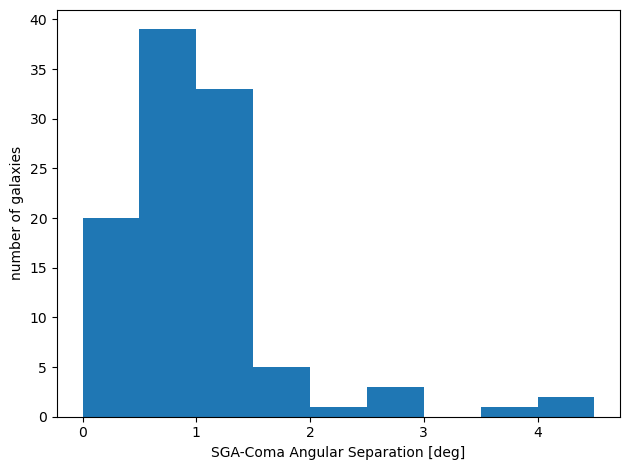

In [10]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

In [11]:
# FP galaxies in Coma (file from Khaled)
FP_gals = Table.read('FP_Coma.csv')
FP_gals[:5]

ra_1,dec_1,z_x
float64,float64,float64
192.260476663904,26.8931119632851,0.0246198717561043
193.57922538261,27.0680307191934,0.0278119786253126
193.922076429039,27.2507625946949,0.0236939766987014
194.221419596724,27.929491498853,0.0204785348754562
193.999798015234,28.1869350114414,0.018663981014227


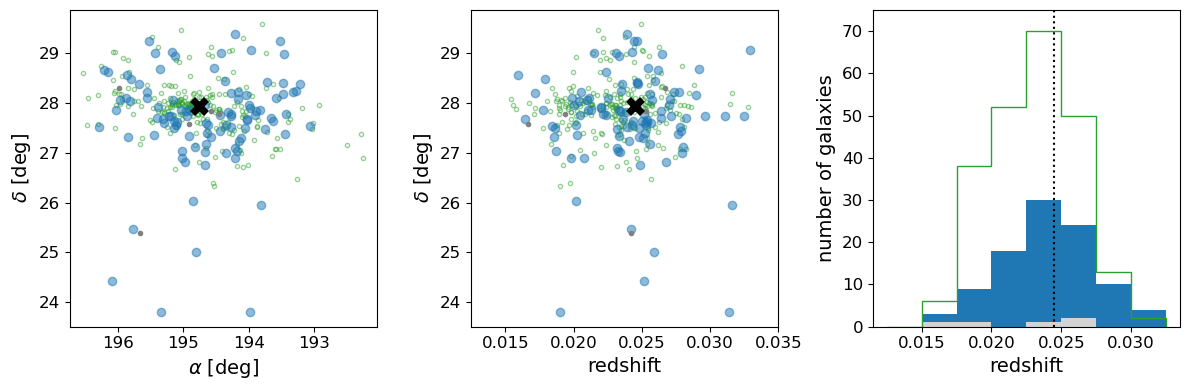

In [26]:
plt.figure(figsize=(12,4), tight_layout=True)

plt.subplot(131)
plt.plot(FP_gals['ra_1'], FP_gals['dec_1'], '.', c='tab:green', alpha=0.5, mfc='none')
plt.plot(SGA_TF_Coma['RA'][~tf_dwarf_boolean], SGA_TF_Coma['DEC'][~tf_dwarf_boolean], 'o', alpha=0.5)
plt.plot(SGA_TF_Coma['RA'][tf_dwarf_boolean], SGA_TF_Coma['DEC'][tf_dwarf_boolean], '.', c='gray')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.gca().invert_xaxis()
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(132)
plt.plot(FP_gals['z_x'], FP_gals['dec_1'], '.', c='tab:green', alpha=0.5, mfc='none')
plt.plot(SGA_TF_Coma['Z_DESI'][~tf_dwarf_boolean], SGA_TF_Coma['DEC'][~tf_dwarf_boolean], 'o', alpha=0.5)
plt.plot(SGA_TF_Coma['Z_DESI'][tf_dwarf_boolean], SGA_TF_Coma['DEC'][tf_dwarf_boolean], '.', c='gray')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlim((0.0125, 0.035))
plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(133)
plt.hist(FP_gals['z_x'], bins=np.arange(0.0125, 0.035, 0.0025), color='tab:green', histtype='step')
plt.hist(SGA_TF_Coma['Z_DESI'][~tf_dwarf_boolean], bins=np.arange(0.0125, 0.035, 0.0025))
plt.hist(SGA_TF_Coma['Z_DESI'][tf_dwarf_boolean], bins=np.arange(0.0125, 0.035, 0.0025), color='lightgray')
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.ylim(ymax=75)
plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/SV/fuji_Coma_galaxies.png', dpi=150);

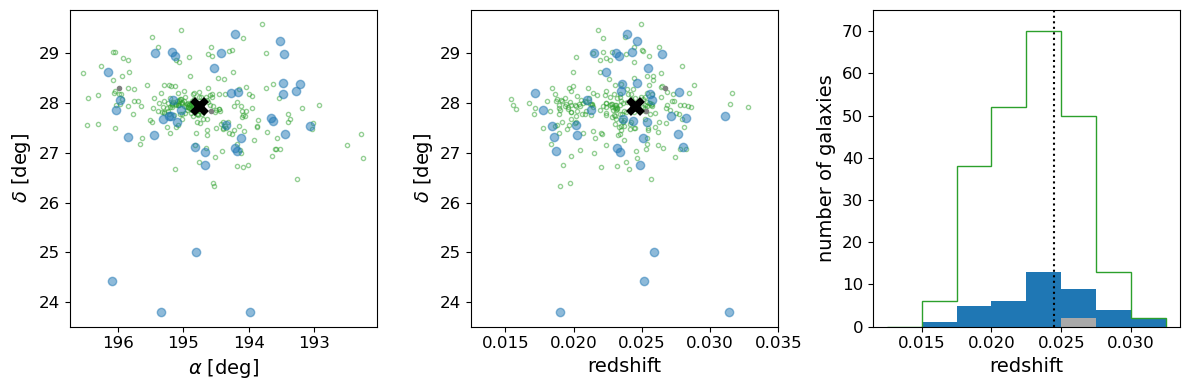

In [25]:
# Version of the above figure with only those Coma galaxies used in the calibration
SGAIDs_cal = Table.read('fuji_Coma_SGAids_calibration.txt', format='ascii.commented_header')
cal_boolean = np.zeros(len(SGA_TF_Coma), dtype=bool)
for i in range(len(SGAIDs_cal)):
    if SGAIDs_cal['SGAID'][i] in SGA_TF_Coma_dict.keys():
        cal_boolean[SGA_TF_Coma_dict[SGAIDs_cal['SGAID'][i]]] = True

plt.figure(figsize=(12,4), tight_layout=True)

plt.subplot(131)
plt.plot(FP_gals['ra_1'], FP_gals['dec_1'], '.', c='tab:green', alpha=0.5, mfc='none')
plt.plot(SGA_TF_Coma['RA'][cal_boolean & ~tf_dwarf_boolean], 
         SGA_TF_Coma['DEC'][cal_boolean & ~tf_dwarf_boolean], 
         'o', 
         alpha=0.5)
plt.plot(SGA_TF_Coma['RA'][cal_boolean & tf_dwarf_boolean], 
         SGA_TF_Coma['DEC'][cal_boolean & tf_dwarf_boolean], 
         '.', 
         c='gray')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, 
         Coma_coords.transform_to('icrs').dec.deg, 
         'kx', 
         ms=10, 
         mew=5)
plt.gca().invert_xaxis()
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(132)
plt.plot(FP_gals['z_x'], FP_gals['dec_1'], '.', c='tab:green', alpha=0.5, mfc='none')
plt.plot(SGA_TF_Coma['Z_DESI'][cal_boolean & ~tf_dwarf_boolean], 
         SGA_TF_Coma['DEC'][cal_boolean & ~tf_dwarf_boolean], 
         'o', 
         alpha=0.5)
plt.plot(SGA_TF_Coma['Z_DESI'][cal_boolean & tf_dwarf_boolean], 
         SGA_TF_Coma['DEC'][cal_boolean & tf_dwarf_boolean], 
         '.', 
         c='gray')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlim((0.0125, 0.035))
plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(133)
plt.hist(FP_gals['z_x'], bins=np.arange(0.0125, 0.035, 0.0025), color='tab:green', histtype='step')
plt.hist(SGA_TF_Coma['Z_DESI'][cal_boolean & ~tf_dwarf_boolean], bins=np.arange(0.0125, 0.035, 0.0025))
plt.hist(SGA_TF_Coma['Z_DESI'][cal_boolean & tf_dwarf_boolean], 
         bins=np.arange(0.0125, 0.035, 0.0025), 
         color='darkgray')
plt.vlines(V_Coma/c, 0, 85, colors='k', linestyles='dotted')
plt.xlabel('redshift', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.ylim(ymax=75)
plt.tick_params(axis='both', which='major', labelsize=12);

plt.savefig('../../Figures/SV/fuji_Coma_cal_galaxies.png', dpi=150);

### Coma calibration galaxies table

Create a LaTeX table with the properties of the 42 galaxies in Coma that were used to calibrate the SV TFR.

In [29]:
columns_to_print = ['SGA_ID', 'RA', 'DEC', 'Z_DESI', 'ZERR_DESI', 'D26', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'V_0p33R26', 'V_0p33R26_err']

SGA_TF_Coma[columns_to_print][cal_boolean].write('fuji_Coma_cal_galaxies.tex', 
                                                 format='ascii.latex', 
                                                 latexdict={'tabletype': 'deluxetable*'})

### Calculate average distance modulus

We will use the weighted mean,
\begin{equation}
  \overline{\mu} = \frac{\sum_i w_i \mu_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

#### with dwarfs

In [23]:
weights = 1./SGA_TF_Coma['mu_TF_err']**2

mu_coma_avg = np.average(SGA_TF_Coma['mu_TF'], weights=weights)
mu_coma_avg_err = np.sqrt(1./np.sum(weights))

KeyError: 'mu_TF_err'

In [32]:
# Convert to distance
d_coma_avg = 10*10**(mu_coma_avg/5) # pc/h
d_coma_avg_Mpc = d_coma_avg/1e6

d_coma_avg_err = d_coma_avg*0.2*np.log(10)*mu_coma_avg_err
d_coma_avg_err_Mpc = d_coma_avg_err/1e6

print(f'Distance modulus to Coma: {mu_coma_avg:.3f} +/- {mu_coma_avg_err:.3f}')
print(f'Distance to Coma: {d_coma_avg_Mpc:.2f} +/- {d_coma_avg_err_Mpc:.2f} Mpc/h')

Distance modulus to Coma: 34.848 +/- 0.033
Distance to Coma: 93.23 +/- 1.42 Mpc/h


#### without dwarfs

In [24]:
weights_bright = 1./SGA_TF_Coma['mu_TFbright_err'][~tf_dwarf_boolean]**2

mu_bright_coma_avg = np.average(SGA_TF_Coma['mu_TFbright'][~tf_dwarf_boolean], weights=weights_bright)
mu_bright_coma_avg_err = np.sqrt(1./np.sum(weights_bright))

In [25]:
# Convert to distance
d_bright_coma_avg = 10*10**(mu_bright_coma_avg/5) # pc/h
d_bright_coma_avg_Mpc = d_bright_coma_avg/1e6

d_bright_coma_avg_err = d_bright_coma_avg*0.2*np.log(10)*mu_bright_coma_avg_err
d_bright_coma_avg_err_Mpc = d_bright_coma_avg_err/1e6

print(f'Distance modulus to Coma: {mu_bright_coma_avg:.3f} +/- {mu_bright_coma_avg_err:.3f}')
print(f'Distance to Coma: {d_bright_coma_avg_Mpc:.2f} +/- {d_bright_coma_avg_err_Mpc:.2f} Mpc/h')

Distance modulus to Coma: 34.812 +/- 0.037
Distance to Coma: 91.69 +/- 1.55 Mpc/h
